<a href="https://colab.research.google.com/github/minhaz19/Builerplate-Next-JS-Tailwind-CSS-ReduxtJS-toolkit-typescript/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

df = pd.read_csv('/content/DSEX + Dow - Sheet1 (1).csv')
df['Date']= pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df.head()

,Price,Dow,Oil,Exchange Rate,Interest Rate,RSI_14,MACD
Date,,,,,,,
2013-01-30,4126.75,13971.24,97.94,79.60,6.0,0,0
2013-01-31,4136.30,14018.70,97.49,79.10,6.0,0,0
2013-02-03,4163.82,13982.91,97.77,78.60,6.0,0,0
2013-02-04,4164.62,13973.39,96.17,78.85,6.0,0,0
2013-02-05,4191.50,13981.76,96.64,78.60,6.0,1,0


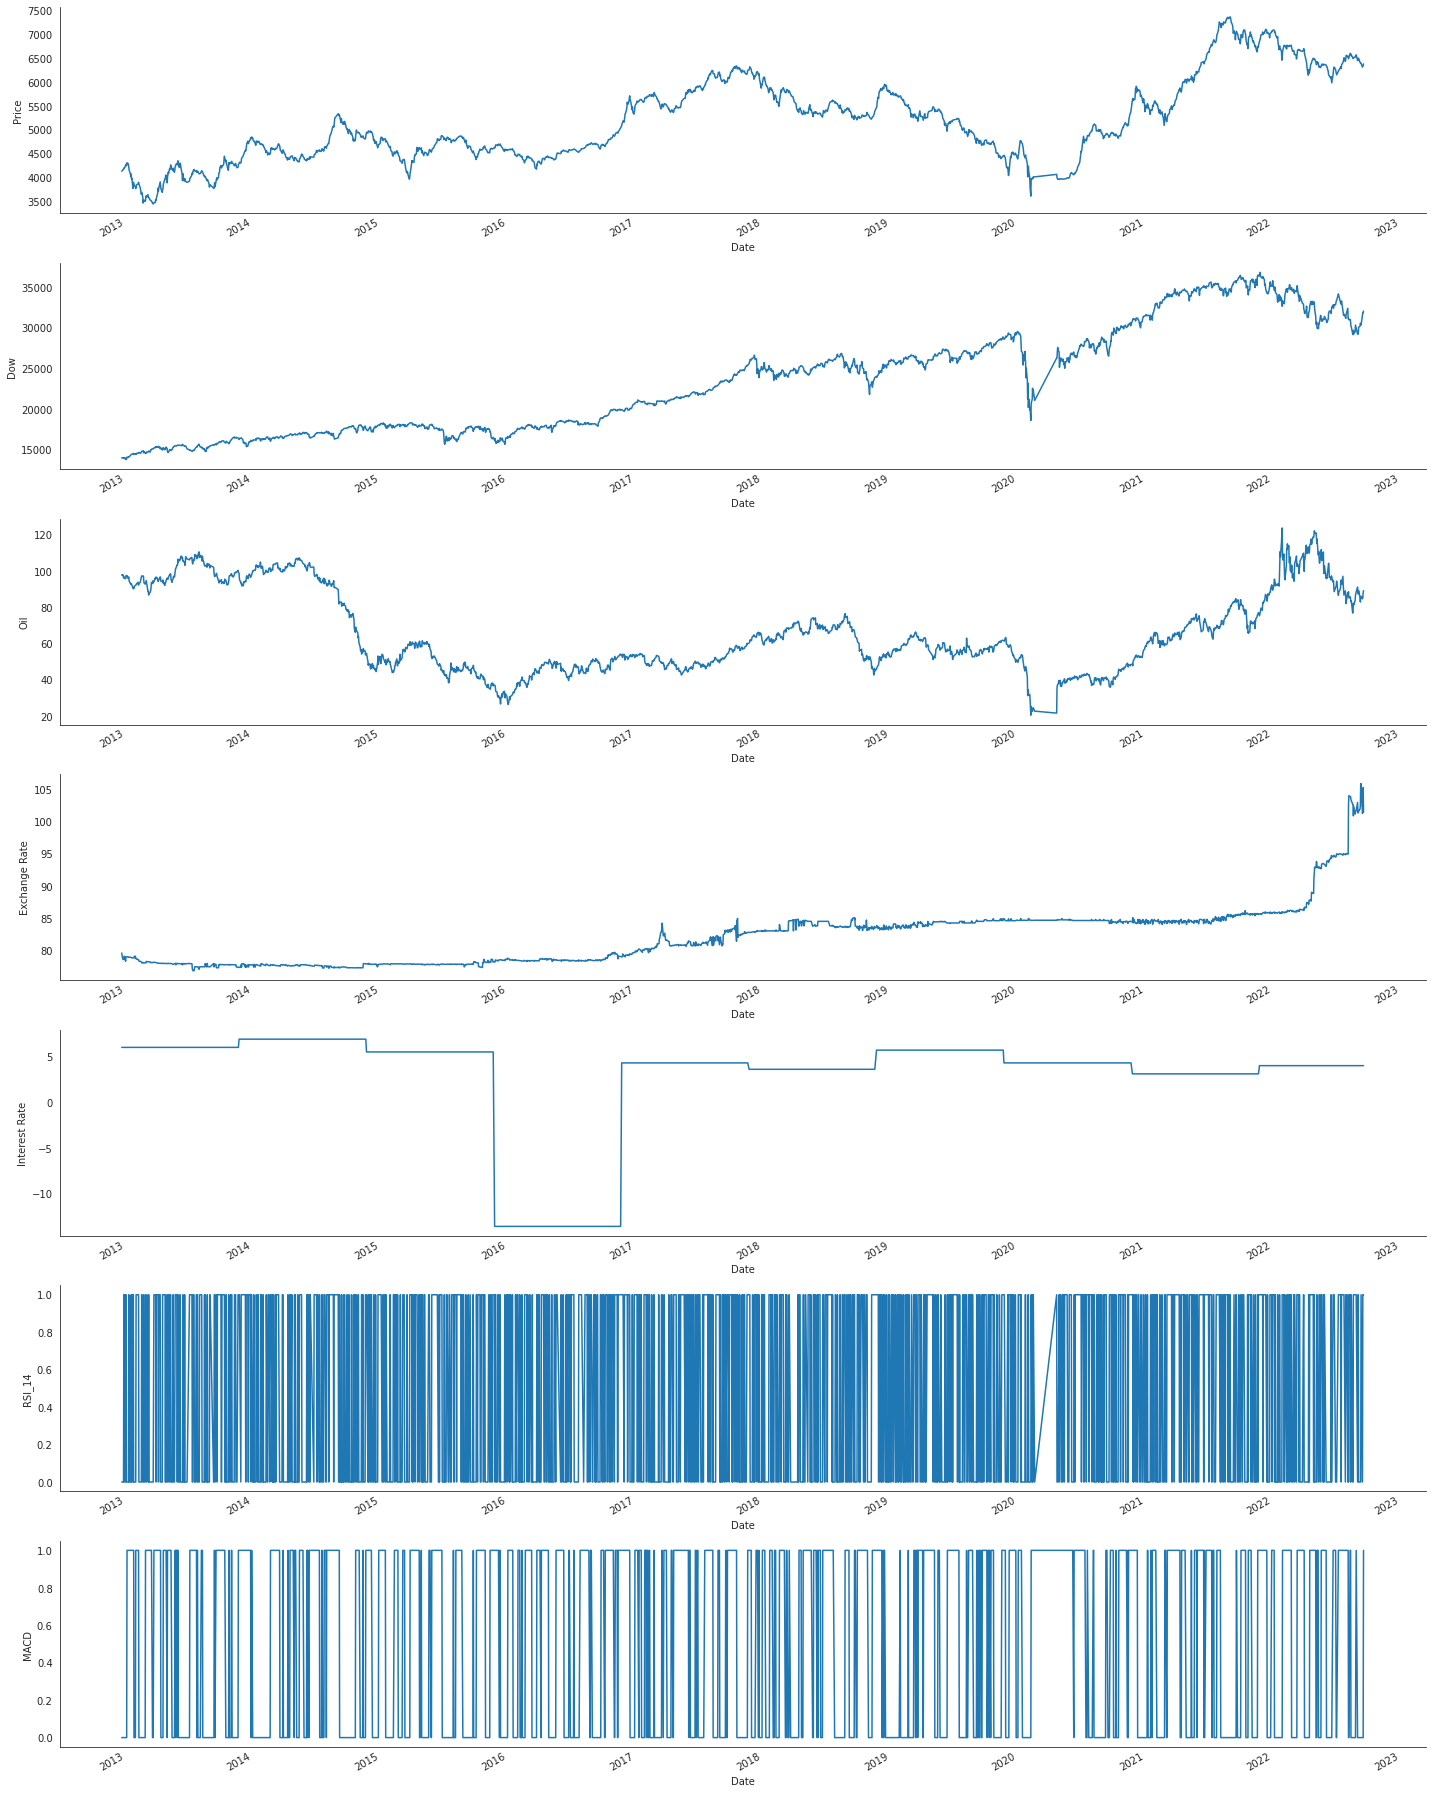

In [ ]:
df_plot = df.copy()

ncols = 1
nrows = 7

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=(20, 25))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [ ]:
train_df = df.sort_values(by=['Date']).copy()

FEATURES = ['Price', 'Dow', 'Oil', 'Exchange Rate', 'Interest Rate', 'RSI_14', 'MACD']

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Price']

data_filtered_ext.tail()

FEATURE LIST
['Price', 'Dow', 'Oil', 'Exchange Rate', 'Interest Rate', 'RSI_14', 'MACD']


,Price,Dow,Oil,Exchange Rate,Interest Rate,RSI_14,MACD,Prediction
Date,,,,,,,,
2022-10-20,6392.30,30332.80,85.98,105.82,4.0,1,0,6392.30
2022-10-24,6311.38,31500.61,84.58,101.20,4.0,0,0,6311.38
2022-10-25,6328.20,31837.20,85.32,101.50,4.0,1,0,6328.20
2022-10-26,6344.35,31840.10,87.91,105.20,4.0,1,0,6344.35
2022-10-27,6378.00,32037.83,89.08,101.40,4.0,1,1,6378.00


In [ ]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Price'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2301, 7)


In [ ]:
sequence_length = 100

index_Close = data.columns.get_loc("Price")

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i, index_Close]) 

    x = np.array(x)
    y = np.array(y)
    return x, y


x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1741, 100, 7) (1741,)
(460, 100, 7) (460,)
0.19986001883382964
0.19986001883382964


In [ ]:
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(GRU(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(GRU(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

700 100 7


In [ ]:
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    

Epoch 1/50
109/109 [==============================] - 12s 43ms/step - loss: 0.0372 - val_loss: 4.5791e-04
Epoch 2/50
109/109 [==============================] - 4s 35ms/step - loss: 2.0363e-04 - val_loss: 6.9587e-04
Epoch 3/50
109/109 [==============================] - 4s 38ms/step - loss: 1.9754e-04 - val_loss: 3.1750e-04
Epoch 4/50
109/109 [==============================] - 4s 36ms/step - loss: 1.9965e-04 - val_loss: 2.4850e-04
Epoch 5/50
109/109 [==============================] - 4s 36ms/step - loss: 2.0946e-04 - val_loss: 5.0260e-04
Epoch 6/50
109/109 [==============================] - 4s 36ms/step - loss: 2.4054e-04 - val_loss: 3.8450e-04
Epoch 7/50
109/109 [==============================] - 4s 38ms/step - loss: 1.8089e-04 - val_loss: 3.8160e-04
Epoch 8/50
109/109 [==============================] - 4s 37ms/step - loss: 1.9816e-04 - val_loss: 4.1496e-04
Epoch 9/50
109/109 [==============================] - 4s 36ms/step - loss: 2.0964e-04 - val_loss: 8.9980e-04
Epoch 10/50
109/109 [=

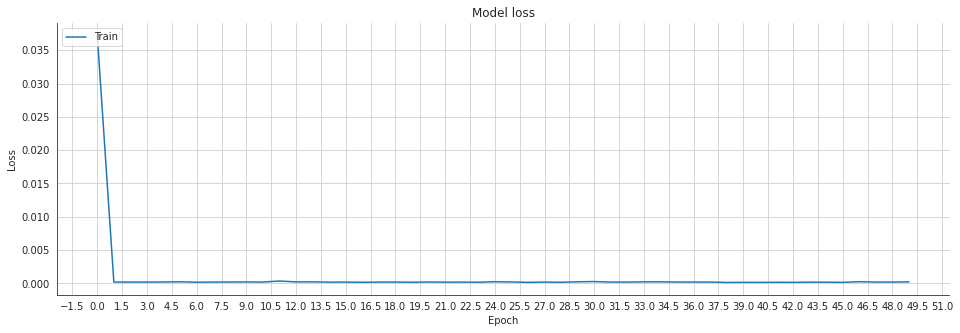

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
y_pred_scaled = model.predict(x_test)


y_pred = scaler_pred.inverse_transform(y_pred_scaled)

y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))


MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)}%')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)}%')

mse = mean_squared_error(y_test_unscaled, y_pred)
rmse = sqrt(mse)
r = r2_score(y_test_unscaled, y_pred)

print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'r: {r}')

15/15 [==============================] - 1s 19ms/step
Median Absolute Error (MAE): 43.58
Mean Absolute Percentage Error (MAPE): 0.7%
Median Absolute Percentage Error (MDAPE): 0.56%
mse: 3220.2565190337227
rmse: 56.74730406842005
r: 0.9925120306603995


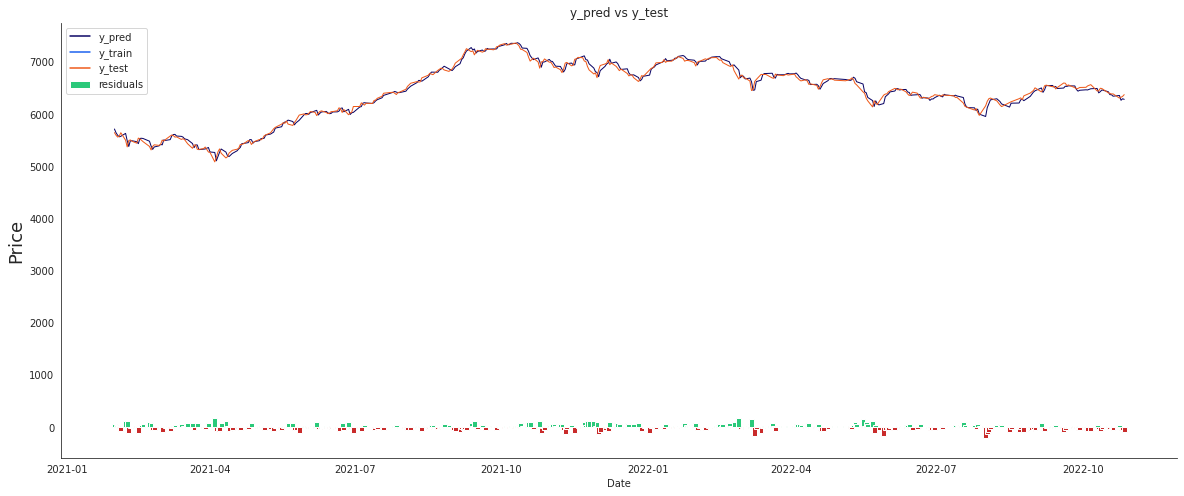

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

display_start_date = "2021-01-30" 

train = pd.DataFrame(data_filtered_ext['Price'][:train_data_len + 1]).rename(columns={'Price': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Price'][train_data_len:]).rename(columns={'Price': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

df_union_zoom = df_union[df_union.index> display_start_date]


fig, ax1 = plt.subplots(figsize=(20, 8))
plt.title("y_pred vs y_test")
plt.ylabel('Price', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
df_union_zoom.to_csv('data.csv', encoding = 'utf-8-sig') 
files.download('data.csv')
